# Semantic Layer Construction

In this notebook we demo the usage of agentic schema refinement for the construction of a semantic layer.

In [7]:
import os
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from IPython.utils import io

import ast
import tiktoken
import snowflake.connector
# import relationalai as rai

from src.utils import prompt_llm, extract_json_from_llm_response, flatten, text_embedding
from src.database import SQLiteDatabase, SnowflakeDatabase
from src.database_utils import copy_local_database, create_local_database, create_snowflake_database
from src.postprocess import process_views
from src.refinement import refine_schema
from src.finetune import finetune

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, to_tree, leaves_list, cut_tree
import hdbscan

In [8]:
database_name = 'dummy_db'
cache_seed = 500
temperature = 1.0
verify = True           # whether to use view verification
n_chats = 12            # number of chats in a sequence
subsample = True        # whether to subsample tables in each chat sequence
n_samples = 10          # number of restarts, with different subschema samples
n_sampled_tables = 5    # size of subschema sample processed in each chat sequence
sample_data = True      # whether to include sample data in the schema description
result_version = 'refine_latest'
database_file = os.path.join('./workspace', database_name, 'database.db')
workspace = os.path.join('./workspace', database_name, result_version)
os.makedirs(workspace, exist_ok=True)

## Database interface

### Local (SQLite)

In [9]:
db = SQLiteDatabase(database_name, database_file)

print(db.database_name)

tables = db.get_tables()
print(tables)

schema_dictionary = db.schema_dictionary()
print(schema_dictionary)

schema_wording = db.schema_wording(sample_size=5)
print(schema_wording)

schema_graph = db.schema_graph()
print(schema_graph.nodes(data=True))

dummy_db
['customers', 'orders', 'suppliers', 'products', 'order_items']
{'customers': ['id', 'name', 'email', 'addr', 'phone', 'crd_lmt', 'birth_dt', 'email_verified', 'phone_verified', 'rank', 'registr_dt'], 'orders': ['id', 'cu_id', 'order_dt', 'tot_paid', 'status', 'tracking_no', 'transp_co', 'itm_cnt', 'off_code'], 'suppliers': ['id', 'nm', 'contact_nm', 'email', 'phone', 'addr'], 'products': ['id', 'nm', 'price', 'cat', 'su_id'], 'order_items': ['id', 'o_id', 'p_id', 'quant', 'price_paid', 'disc_amt', 'reshipped', 'return_policy']}
CREATE TABLE customers (
  id INT PRIMARY KEY,
  name VARCHAR(50),
  email VARCHAR(100),
  addr VARCHAR(100),
  phone VARCHAR(20),
  crd_lmt DECIMAL(10, 2),
  birth_dt DATE,
  email_verified BOOLEAN,
  phone_verified BOOLEAN,
  rank INT,
  registr_dt DATE
);

-- Sample Data:
(1, 'John Doe', 'johndoe@example.com', '123 Elm St', '555-1234', 1000, '1985-01-15', 1, 1, 5, '2020-05-01')
(2, 'Jane Smith', 'janesmith@example.com', '456 Maple St', '555-5678', 1

## Multi-agent Schema Refinement

### 1. Schema Refinement

Run the multi-agent refinement framework. During the schema refinement process agents have individual chat sessions where they engage in view creation.
The chat log will be used to extract views in the next stage.

In [10]:
# TODO: Use the autogen_logs directly. They are being generated but have issues in message ordering.
instructions_file = './agent_instructions.yml'
with io.capture_output() as captured:
    chat_history, code_history = refine_schema(db, workspace, instructions_file, cache_seed=cache_seed, temperature=temperature, verify=verify, n_chats=n_chats, subsample=subsample, n_samples=n_samples, sample_size=n_sampled_tables, sample_data=sample_data)

log_file = os.path.join(workspace, f'refine_{database_name}.log')
with open(log_file, "w") as f:
    f.write(captured.stdout)

### 2. Postprocessing

* The chat log is parsed into individual chats. (`refine_<database_name>_chats.jsonl`)
* Each chat is then processed by an LLM agent to extact one or more pairs of a high level analysis task together with the set of views that are useful to solve the task. This dataset will be used for instruction tuning in the next stage. (`refine_<database_name>_task_views.jsonl`)
* Each view definition is parsed by a SQL parser to detect the original tables and columns it uses. The set of original tables and columns are called sources. Views that share sources are later associated in a graph. (`refine_<database_name>_sql_parsed.jsonl`)

In [ ]:
log_file = os.path.join(workspace, f'refine_{db.database_name}.log')
process_views(db, workspace, log_file, generate_instructions=True)

### 3. Finetuning

The Instruction Tuning dataset from the previous stage (`refine_<database_name>_task_views.jsonl`) is used to fine tune an LLM assistant called *"Lens"*. The user can then query the assistant with a high-level description of a task they want to solve, and the assistant replies with a set of views that might be helpful for the task. 

In [12]:
training_file = os.path.join(workspace, f'refine_{database_name}_task_views.jsonl')
finetune(training_file, suffix=f'Lens-{database_name}', base_model='gpt-3.5-turbo', n_epochs=4)

## Semantic Layer Construction

We postprocess the views to create an ER taxonomy and provide *Hierarchical Access* to the semantic layer.

### Retrieve Views 

Start by retrieving the generated views. The view definitions are previously parsed by a SQL parser (`refine_<database_name>_sql_parsed.jsonl`). For each view, 
* Find the source tables and columns that appear in the view definitions. Note, we only care about columns that appear in the header, as these are the attributes the view contains. It is possible that interemediate columns are used to connect data from different tables, i.e., in JOIN statements.  
* Generate textual descriptions for the views. We ask an LLM model to generate a one-sentence description for the each view, given the view definition. The description should focus on the semantic interpretation rather that the structure.

In [13]:
views_parsed_file = os.path.join(workspace, f'refine_{db.database_name}_sql_parsed.jsonl')

In [14]:
df = pd.DataFrame(columns=['view_name', 'view_description', 'tables', 'columns', 'sql'])

# TODO: handle views defined with nested queries (multiple SELECT clauses)

with open(views_parsed_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        view_dict = json.loads(line)
        if isinstance(view_dict['sql_parsed'], dict):
            if view_dict['view_name']:
                view_name = view_dict['view_name'].replace('__', ' ').replace('_', ' ')
                column_set = set([c for c in flatten(view_dict['sql_parsed']['select']) if isinstance(c, str)])
                table_set = set([c.split('.')[0] for c in column_set]) # keep only the tables that appear in the header
                if '__all__' in column_set:
                    continue
                llm_description = prompt_llm(f"Provide a one-sentence description for the database view defined as follows: {view_dict['sql']} . Focus on the semantic interpretation rather that the structure. Reply with one short sentence.", "You are a database expert.")
                _columns_in_header = [c.replace('__', ' ').replace('_', ' ') for c in column_set]
                sources = ['column {} from table {}'.format(c.split('.')[1], c.split('.')[0]) for c in _columns_in_header]
                text = "Name: {}. Sources: {}. Description: {}".format(view_name, ', '.join(sources), llm_description)
                view_data ={'view_name': view_dict['view_name'], 'view_description': text, 'tables': table_set, 'columns': column_set, 'sql': view_dict['sql']}
                df = pd.concat([df, pd.DataFrame([view_data])], ignore_index=True)

display(df.head())
print('Total number of views:', len(df))

,view_name,view_description,tables,columns,sql
0,order_items_products,Name: order items products. Sources: column nm...,"{__products, __order_items}","{__products.nm__, __order_items.price_paid__, ...",CREATE VIEW order_items_products AS SELECT oi....
1,sold_items,Name: sold items. Sources: column price paid ...,{__order_items_products},"{__order_items_products.price_paid__, __order_...","CREATE VIEW sold_items AS SELECT product_id, c..."
2,unique_product_orders,Name: unique product orders. Sources: column p...,"{__order_items, __orders}","{__order_items.p_id__, __orders.cu_id__}",CREATE VIEW unique_product_orders AS SELECT cu...
3,average_expenditure_per_age_group,Name: average expenditure per age group. Sourc...,"{__customers_age_at_order, __orders}","{__customers_age_at_order.age_at_order__, __or...",CREATE VIEW average_expenditure_per_age_group ...
4,customer_age_group_analysis,Name: customer age group analysis. Sources: co...,"{__average_expenditure_per_age_group, __popula...",{__popular_products_by_age_group.product_name_...,CREATE VIEW customer_age_group_analysis AS SEL...


Total number of views: 122


Sometimes, duplicate views are defined. We remove the duplicates here. Note, only views with the same exact definition are considered duplicates. We retain views with the same name but different definitions.

In [15]:
# How many duplicates are there in the views? , deduplicate view definitions
df = df.drop_duplicates(subset=['sql'])

### View Embeddings

Use the textual descriptions previously generated to produce embeddings. Save the dataframe that contains descriptions, table and column sources together with the embedding in the workspace. (`refine_<database_name>_views.csv`)

In [16]:
df['embedding'] = df.view_description.apply(lambda x: text_embedding(x, model='text-embedding-3-large'))
df.to_csv(os.path.join(workspace, f'refine_{db.database_name}_views.csv'), index=False)

Load the file here to continue the processing.

In [17]:
df = pd.read_csv(os.path.join(workspace, f'refine_{db.database_name}_views.csv'))
df['embedding'] = df['embedding'].apply(lambda x: ast.literal_eval(x))
df['tables'] = df['tables'].apply(lambda x: ast.literal_eval(x))
df['columns'] = df['columns'].apply(lambda x: ast.literal_eval(x))
display(df.head())
print('Total number of views:', len(df))

,view_name,view_description,tables,columns,sql,embedding
0,order_items_products,Name: order items products. Sources: column nm...,"{__products, __order_items}","{__products.nm__, __order_items.disc_amt__, __...",CREATE VIEW order_items_products AS SELECT oi....,"[-0.07052461802959442, -0.002290765754878521, ..."
1,sold_items,Name: sold items. Sources: column price paid ...,{__order_items_products},"{__order_items_products.price_paid__, __order_...","CREATE VIEW sold_items AS SELECT product_id, c...","[-0.02505391649901867, -0.01448429562151432, -..."
2,unique_product_orders,Name: unique product orders. Sources: column p...,"{__order_items, __orders}","{__order_items.p_id__, __orders.cu_id__}",CREATE VIEW unique_product_orders AS SELECT cu...,"[-0.03361525014042854, 0.00390665652230382, -0..."
3,average_expenditure_per_age_group,Name: average expenditure per age group. Sourc...,"{__customers_age_at_order, __orders}","{__customers_age_at_order.age_at_order__, __or...",CREATE VIEW average_expenditure_per_age_group ...,"[-0.04403838887810707, 0.007944513112306595, -..."
4,customer_age_group_analysis,Name: customer age group analysis. Sources: co...,"{__average_expenditure_per_age_group, __popula...",{__popular_products_by_age_group.product_name_...,CREATE VIEW customer_age_group_analysis AS SEL...,"[-0.050372641533613205, -0.01658686064183712, ..."


Total number of views: 47


### Hierarchical Access

### Classic methods 
Using SciPy implementations. ([see documentation](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy))

1. Flat clustering: (kmeans, elbow method) 
    - Determine the maximum number of clusters for all views (`max_n_clusters`)
    - Examining each cluster, produce an initial list of entities

2. Categorize each view as "entity" (corresponds to an entity and one or more of its attributes) or "relation" (corresponds to a link between two or more distinct entities), using the list as a basis

3. Taxonomy (hierarchical clustering)
    - Apply hierarchical clustering only for the views categorized as entities: `linkage`, `dendrogram`
    - Produce flat clusters at different levels of the dendrogram, i.e., corresponds to a taxonomy of classes 
    - Discover class-subclass relations
    - Discover intra-level relations

#### Determine the number of clusters with flat clustering methods. Here we use 1. the silhouette score method 2. the elbow method

The average silhouette score for 5 clusters is 0.15676904689646148
The average silhouette score for 10 clusters is 0.20492770693505244
The average silhouette score for 15 clusters is 0.20067285640438534
The average silhouette score for 20 clusters is 0.1787142553430421
The highest silhouette score is 0.205 for 10 clusters. (suggested number of clusters)
The decrease rate of WCSS is [0.417, 0.36, 0.382]. (look for the elbow in descrease rate)


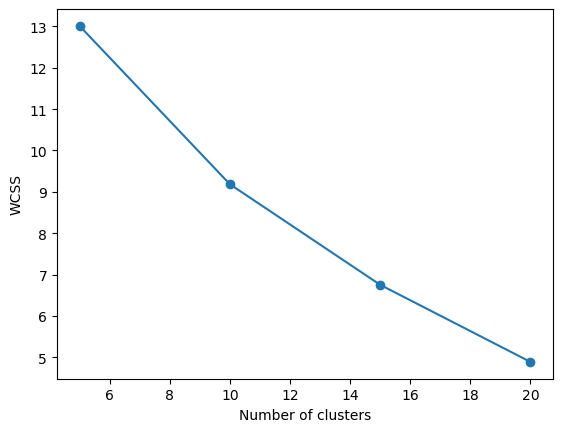

In [18]:
data = np.array(df['embedding'].tolist())

step = 5
max_clusters = len(data)//2
min_clusters = 5

n_clusters_l = list(range(min_clusters, max_clusters, step))

wcss_l = []
sil_score_max = -1 # this is the minimum possible score
for n_clusters in n_clusters_l:
  kmeans = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=100, n_init=50)
  labels = kmeans.fit_predict(data)
  sil_score = silhouette_score(data, labels)
  wcss_l.append(kmeans.inertia_)
  print("The average silhouette score for {} clusters is {}".format(n_clusters,sil_score))
  if sil_score > sil_score_max:
    sil_score_max = sil_score
    best_n_clusters = n_clusters

print("The highest silhouette score is {} for {} clusters. (suggested number of clusters)".format(round(sil_score_max, 3), best_n_clusters))
print("The decrease rate of WCSS is {}. (look for the elbow in descrease rate)".format([round((wcss_l[i] - wcss_l[i+1])/wcss_l[i+1], 3) for i in range(len(wcss_l)-1)]))

# Plot the Elbow method
plt.plot(n_clusters_l, wcss_l, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()

In [19]:
max_n_clusters = 15

#### Use flat clustering (k-Means) to cluster the views into semantic groups. 

Ideally, each flat cluster should represent a single entity or relation.

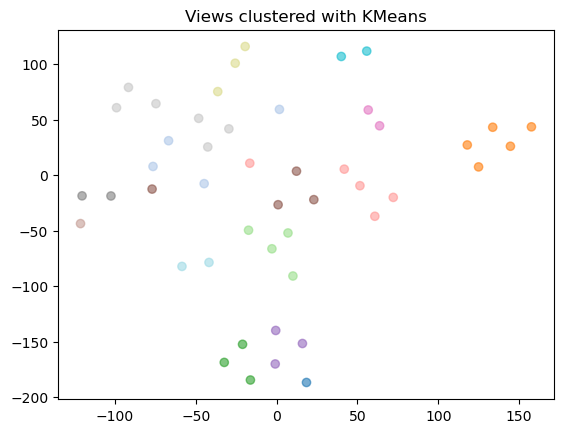

In [20]:
data = np.array(df['embedding'].tolist())
matrix = np.vstack(data)

n_clusters = max_n_clusters
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=100, n_init=1)
labels = kmeans.fit_predict(data)
df['fcluster'] = labels

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

plt.scatter([x for x,y in vis_dims], [y for x,y in vis_dims], c=labels, cmap=matplotlib.colormaps.get_cmap('tab20'), alpha=0.6)
plt.title("Views clustered with KMeans")
plt.show()

#### Use an LLM agent to discover an initial set of entities that appear in the views. 

Specifically, for each group the agent suggests one or more entities.

In [21]:
# Find entities and relations within each cluster
entities = []
for cluster_id in range(n_clusters):
    cluster_description = ""
    cluster_views = df[df.fcluster == cluster_id]
    for index, row in cluster_views.iterrows():
        cluster_description += "View name {} ----- View description {}".format(index, row['view_description']) + '\n'
        # Ask the model to summarize the cluster
        response_format = """{"entities": ["entity1", "entity2", "entity3", ...]}"""
        user_message = f"""Here are a few views I defined on my database:\n{cluster_description}. 
Please, summarize the views into a single entity or list of entities. 
Entities should be general enough to have several attributes. For example, an entity could be a "Customer" and have specific attributes like "customer id", "name", etc. 
Entities could also have relationships with other entities. For example, a "Customer" entity could have a relationship with an "Order" entity, such as customer makes orders.
Entities should be referred to with a concise name. Respond in the following json format: {response_format}. 
Do not include any additional text in your response. Respect the requested format."""

    # Query the model with the task
    response = prompt_llm(user_message, "You are a database expert.", model='gpt-4o')

    # Parse the response
    response_dict = extract_json_from_llm_response(response, verbose=False)
    if response_dict:
        entities += response_dict['entities']
    else:
        print("No valid JSON found in the response. Response:", response)

# deduplicate entities
entities = list(set(entities))
entities

['Performance',
 'Return',
 'Transporter',
 'YearlyRetainedCustomerStats',
 'OrderItem',
 'OrderDay',
 'Customer',
 'MonthlySalesStatistics',
 'ProductCategory',
 'AgeGroup',
 'Supplier',
 'Product',
 'Order',
 'Category',
 'Month',
 'PriceRange']

#### Using the initial collection of entities, we ask an LLM agent to categorize every view as an entity view or relation view. 

In [22]:
# For each view, determine whether it represents an entity or a relation
for index, row in df.iterrows():
    view_dict = row.to_dict()
    llm_categorization = prompt_llm(f"I have a database view defined as follows: {view_dict['sql']}. The database view can be semantically interpreted as follows: {view_dict['view_description']}. Determine whether the view represents an entity and each properties or a relation between two or more distinct entities. For example, entities may include: {', '.join(entities)}. Reply with one word: 'entity' or 'relation'.", "You are a database expert.")
    df.loc[index, 'view_category'] = 'entity' if 'entity' in llm_categorization.lower() else 'relation'

#### We apply hierarchical clustering separately for the entity views and the relation views. 

Our goal is to reveal a hierarchical structure among entities that appear in the views.

In [23]:
entity_data = np.array(df[df['view_category'] == 'entity'].embedding.tolist())
relation_data = np.array(df[df['view_category'] == 'relation'].embedding.tolist())

# Perform hierarchical clustering using linkage method, for entity and relation views separately
Z_entity = linkage(entity_data, method='ward')  # You can also use 'single', 'complete', etc.
Z_relation = linkage(relation_data, method='ward')

# Get the cluster labels, for entity and relation views separately
max_c = max_n_clusters // 2
cluster_labels_entity = fcluster(Z_entity, max_c, criterion='maxclust')
cluster_labels_relation = fcluster(Z_relation, 1.5*max_c, criterion='maxclust')

# separate entity rows and relation rows and reindex
df_temp_entity = df[df['view_category'] == 'entity'].reset_index(drop=True)
df_temp_relation = df[df['view_category'] == 'relation'].reset_index(drop=True)
df_temp = pd.concat([df_temp_entity, df_temp_relation], ignore_index=True)
df_temp['cluster'] = -1
df_temp.loc[df_temp['view_category'] == 'entity', 'cluster'] = cluster_labels_entity
df_temp.loc[df_temp['view_category'] == 'relation', 'cluster'] = cluster_labels_relation + max(cluster_labels_entity) + 1

for cluster, group in df_temp.groupby('cluster'):
    print('Cluster {} - size {}'.format(cluster, len(group)))
    for i, row in group.iterrows():
        print(i, '---', row['view_name'], '---', row['view_category'], '---', row['columns'])
    print('='*50)

Cluster 1 - size 7
1 --- top_5_months_by_orders --- entity --- {'__monthly_orders.order_year__', '__monthly_orders.order_count__', '__monthly_orders.order_month__'}
15 --- highest_monthly_sales --- entity --- {'__monthly_sales_stats.totalsales__', '__monthly_sales_stats.yearmonth__'}
16 --- lowest_monthly_sales --- entity --- {'__monthly_sales_stats.totalsales__', '__monthly_sales_stats.yearmonth__'}
17 --- most_items_sold_month --- entity --- {'__monthly_sales_stats.yearmonth__', '__monthly_sales_stats.totalitems__'}
18 --- least_items_sold_month --- entity --- {'__monthly_sales_stats.yearmonth__', '__monthly_sales_stats.totalitems__'}
19 --- most_customers_month --- entity --- {'__monthly_sales_stats.uniquecustomers__', '__monthly_sales_stats.yearmonth__'}
20 --- least_customers_month --- entity --- {'__monthly_sales_stats.uniquecustomers__', '__monthly_sales_stats.yearmonth__'}
Cluster 2 - size 3
12 --- transporter_orders --- entity --- {'__orders.id__', '__orders.status__', '__orde

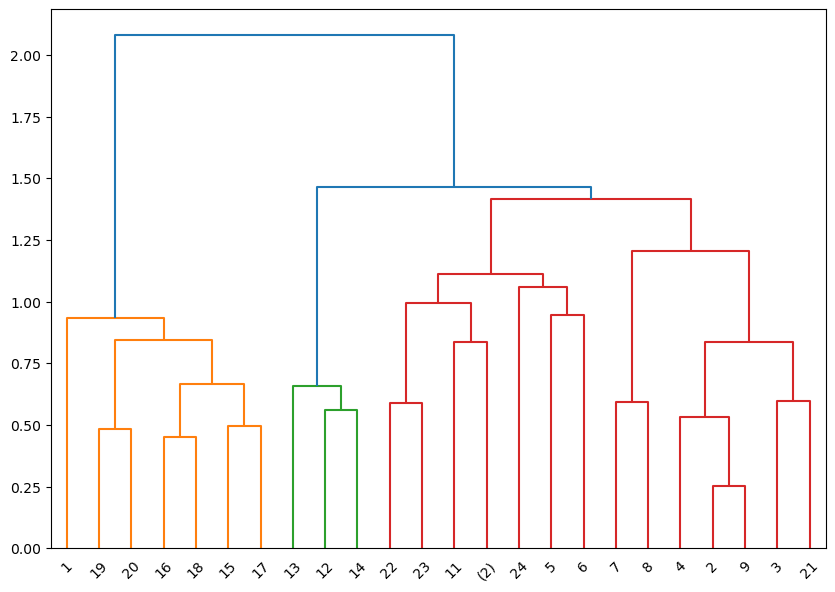

In [24]:
plt.figure(figsize=(10, 7))
dendrogram(Z_entity, p=5, truncate_mode='level', orientation='top', leaf_font_size=10)
plt.show()

#### For each level of the entity view hierarchy, extract flat clusters.

In [25]:
df_entity = df[df['view_category'] == 'entity'].reset_index(drop=True)

n_clusters_levels = range(max_n_clusters, 2, -2)
for i, l in enumerate(n_clusters_levels):
    clusters = cut_tree(Z_entity, n_clusters=l)
    cluster_labels_in_level = clusters.flatten()
    df_entity[f'taxonomy_level_{len(n_clusters_levels) - i - 1}'] = cluster_labels_in_level

display(df_entity.head())

,view_name,view_description,tables,columns,sql,embedding,fcluster,view_category,taxonomy_level_6,taxonomy_level_5,taxonomy_level_4,taxonomy_level_3,taxonomy_level_2,taxonomy_level_1,taxonomy_level_0
0,sold_items,Name: sold items. Sources: column price paid ...,{__order_items_products},"{__order_items_products.price_paid__, __order_...","CREATE VIEW sold_items AS SELECT product_id, c...","[-0.02505391649901867, -0.01448429562151432, -...",11,entity,0,0,0,0,0,0,0
1,top_5_months_by_orders,Name: top 5 months by orders. Sources: column ...,{__monthly_orders},"{__monthly_orders.order_year__, __monthly_orde...",CREATE VIEW top_5_months_by_orders AS SELECT o...,"[-0.019380809739232063, -0.0012990246759727597...",0,entity,1,1,1,1,1,1,1
2,customer_spending,Name: customer spending. Sources: column tot p...,"{__orders, __customers}","{__orders.tot_paid__, __customers.name__, __cu...",CREATE VIEW customer_spending AS SELECT custom...,"[-0.025043893605470657, -0.003842041129246354,...",4,entity,2,2,2,2,2,2,0
3,orders_view,Name: orders view. Sources: column tot paid f...,{__orders},"{__orders.id__, __orders.tot_paid__, __orders....",CREATE VIEW orders_view AS SELECT orders.id AS...,"[-0.018571708351373672, -0.0002927675668615848...",7,entity,3,3,2,2,2,2,0
4,order_spending,Name: order spending. Sources: column order am...,{__orders_view},"{__orders_view.order_amount_spent__, __orders_...",CREATE VIEW order_spending AS SELECT orders_vi...,"[-0.04066882282495499, 0.012857183814048767, -...",4,entity,2,2,2,2,2,2,0


#### For each level of the entity view hierarchy and for each cluster we detect a single entity together with each attributes.

The entities detected in this stage 1. correspond to a specific set of views and 2. are hierarchically organized into a taxonomy.

In [26]:
er_taxonomy = []

In [27]:
for i, l in enumerate(n_clusters_levels):
    level = len(n_clusters_levels) - i - 1
    print("Level {} - Number of clusters: {}".format(level, len(df_entity[f'taxonomy_level_{level}'].unique())))
    for cluster, group in df_entity.groupby(f'taxonomy_level_{level}'):
        # Get the views in the cluster
        cluster_description = ""
        view_ids = []
        view_names = []
        for index, row in group.iterrows():
            cluster_description += "View name {} ----- View description {}".format(index, row['view_description']) + '\n'
            view_ids.append(index)
            view_names.append(row['view_name'])

        # Ask the model to summarize the cluster
        response_format = """
        {
            "entity": "Entity Name",
            "attributes": ["attribute1", "attribute2", "attribute3", ...]
        }
        """
        user_message = f"""Here are a few views I defined on my database:\n{cluster_description}.
Please, summarize the views into a single entity. Then, list the attributes of the entity that appear in the views.
The entity should be described concisely with one word or short phrase. Respond in the following json format: {response_format}.
Do not include any additional text in your response. Respect the requested format."""

        # Query the model with the task
        response = prompt_llm(user_message, "You are a database expert.")

        # Parse the response
        response_dict = extract_json_from_llm_response(response, verbose=False)
        if not response_dict:
            print("No valid JSON found in the response. Response:", response)
            continue

        # Add the entity to the taxonomy
        if level == 0:
            parent_cluster = -1
        else:
            parent_clusters = df_entity[df_entity[f'taxonomy_level_{level}'] == cluster][f'taxonomy_level_{level-1}'].values
            assert len(set(parent_clusters)) == 1, "All parent clusters should be the same"
            parent_cluster = parent_clusters[0]
        print("Parent cluster {} -- Entity: {} - Attributes: {} - Views: {}".format(parent_cluster, response_dict['entity'], response_dict['attributes'], view_ids))
        entity = response_dict['entity']
        attributes = response_dict['attributes']
        views = {'view names': view_names, 'view ids': view_ids}
        # dict: level - cluster - parent cluster - entity - attributes - views 
        er_taxonomy.append({'level': level, 'cluster': cluster, 'parent_cluster': parent_cluster, 'entity': entity, 'attributes': attributes, 'views': views})

Level 6 - Number of clusters: 15
Parent cluster 0 -- Entity: Sales Summary - Attributes: ['price paid', 'product id', 'category', 'quantity', 'p id', 'o id', 'quant'] - Views: [0, 10]
Parent cluster 1 -- Entity: Monthly Orders - Attributes: ['order year', 'order count', 'order month'] - Views: [1]
Parent cluster 2 -- Entity: Customer Spending - Attributes: ['tot paid', 'name', 'id', 'order amount spent', 'order id', 'customer id', 'cu id'] - Views: [2, 4, 9]
Parent cluster 3 -- Entity: OrderSummary - Attributes: ['tot_paid', 'id', 'cu_id', 'order_count'] - Views: [3, 21]
Parent cluster 4 -- Entity: SupplierReturns - Attributes: ['total_num_of_returns', 'total_returned_cost', 'product_id', 'supplier_id'] - Views: [5]
Parent cluster 5 -- Entity: CustomerStats - Attributes: ['tot paid', 'order year', 'customer id'] - Views: [6]
Parent cluster 6 -- Entity: Buying Customers - Attributes: ['customer id', 'customer name'] - Views: [7, 8]
Parent cluster 7 -- Entity: ProductDiscount - Attribute

#### We enrich the taxonomy with intra-level relations. 

Specifically, we map the relation views into relations together with the set of entities they connect. We specifically choose the hierarchy level (`relation_base_level`) where the relation views are best mapped.

In [28]:
# Map relations to the entities they connect
relation_base_level = 5
entities_in_level = [er['entity'] for er in er_taxonomy if er['level'] == relation_base_level]
entities_in_level = list(set(entities_in_level))

df_relation = df[df['view_category'] == 'relation'].reset_index(drop=True)

for index, row in df_relation.iterrows():
    # Get the view
    view_id = index
    view_name = row['view_name']
    sql = row['sql']
    description = row['view_description']

    # Ask the model to assing the relation to the entities
    response_format = """
    {
        "relation": "Relation Name",
        "entities": ["entity1", "entity2", ... etc]
    }
    """

    user_message = f"""I have a database view defined as follows: {sql}. The database view can be semantically interpreted as follows: {description}.
I have the following entities in my database: {', '.join(entities_in_level)}. Please, assign the relation to the set of entities it connects. 
Respond in the following json format: {response_format}. Do not include any additional text in your response. Respect the requested format."""

    # Query the model with the task
    response = prompt_llm(user_message, "You are a database expert.")

    # Parse the response
    response_dict = extract_json_from_llm_response(response, verbose=False)
    if not response_dict:
        print("No valid JSON found in the response. Response:", response)
        continue

    # Add the relation to the taxonomy
    # dict: level - relation - entities - view
    print("Relation: {} - Entities: {}".format(response_dict['relation'], response_dict['entities']))
    relation = response_dict['relation']
    entities = response_dict['entities']
    view = {'view name': view_name, 'view id': view_id}
    er_taxonomy.append({'level': relation_base_level, 'relation': relation, 'entities': entities, 'view': view})


Relation: order_items_products - Entities: ['Product', 'Order']
Relation: unique_product_orders - Entities: ['Order', 'Product']
Relation: average_expenditure_per_age_group - Entities: ['Customer Spending', 'Order']
Relation: customer_age_group_analysis - Entities: ['Customer Statistics', 'Product', 'Order']
Relation: returned_items_by_product_customer - Entities: ['Order', 'Product']
Relation: product_sales_performance - Entities: ['Product', 'OrderSummary', 'Sales Summary', 'SupplierReturnSummary']
Relation: orders_delivered_with_customer_info - Entities: ['Order', 'Customer Statistics']
Relation: orders_canceled_with_customer_info - Entities: ['Order', 'Customer Statistics']
Relation: product_supplier - Entities: ['Product', 'SupplierReturnSummary']
Relation: order_supplier - Entities: ['Order', 'Product']
Relation: product_customers - Entities: ['Order', 'Buying Customers']
Relation: product_statistics - Entities: ['Product', 'Order', 'Customer Statistics']
Relation: category_stati

Save the ER taxonomy in the workspace (`refine_<database_name>_er_taxonomy.jsonl`)

In [29]:
# Save the taxonomy to a file
taxonomy_file = os.path.join(workspace, f'refine_{db.database_name}_er_taxonomy.jsonl')
with open(taxonomy_file, 'w') as f:
    for er in er_taxonomy:
        er_serializable = {k: str(v) for k, v in er.items()}
        f.write(json.dumps(er_serializable) + '\n')

### HDBSCAN 

Source:  [notebook](https://nbviewer.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/How%20HDBSCAN%20Works.ipynb) 

Cluster -1 - size 7
9 --- returned_items_by_product_customer --- {'__order_items.p_id__', '__orders.cu_id__', '__order_items.price_paid__', '__order_items.id__'}
10 --- return_totals_by_supplier --- {'__product_supplier_return_totals.product_id__', '__product_supplier_return_totals.total_returned_cost__', '__product_supplier_return_totals.total_num_of_returns__', '__product_supplier_return_totals.supplier_id__'}
11 --- product_sales_performance --- {'__suppliers.nm__', '__products.nm__', '__order_items.price_paid__', '__suppliers.id__', '__products.cat__', '__products.id__', '__order_items.quant__'}
12 --- yearly_retained_customers_stats --- {'__yearly_retained_customers_list.customer_id__', '__yearly_retained_customers_list.order_year__', '__yearly_retained_customers_list.tot_paid__'}
22 --- product_discount --- {'__order_items.p_id__', '__order_items.disc_amt__'}
43 --- day_of_week_avg_items --- {'__order_day.order_day_iso__', '__order_day.item_count__'}
46 --- supplier_performance -

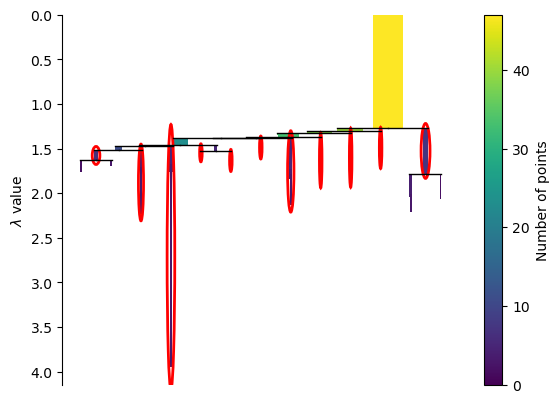

In [30]:
data = np.array(df.embedding.tolist())

clusterer = hdbscan.HDBSCAN(gen_min_span_tree=False, min_cluster_size=2, min_samples=1)
clusterer.fit(data)

cluster_labels = clusterer.labels_

cluster_probs = clusterer.probabilities_

clusterer.condensed_tree_.plot(select_clusters=True)

df_temp = df.copy()
df_temp['cluster'] = cluster_labels

for cluster, group in df_temp.groupby('cluster'):
    print('Cluster {} - size {}'.format(cluster, len(group)))
    for i, row in group.iterrows():
        print(i, '---', row['view_name'], '---', row['columns'])
    print('='*50)

## Column Co-occurrence Graph

Views that share the same source column in their head are connected in a graph.

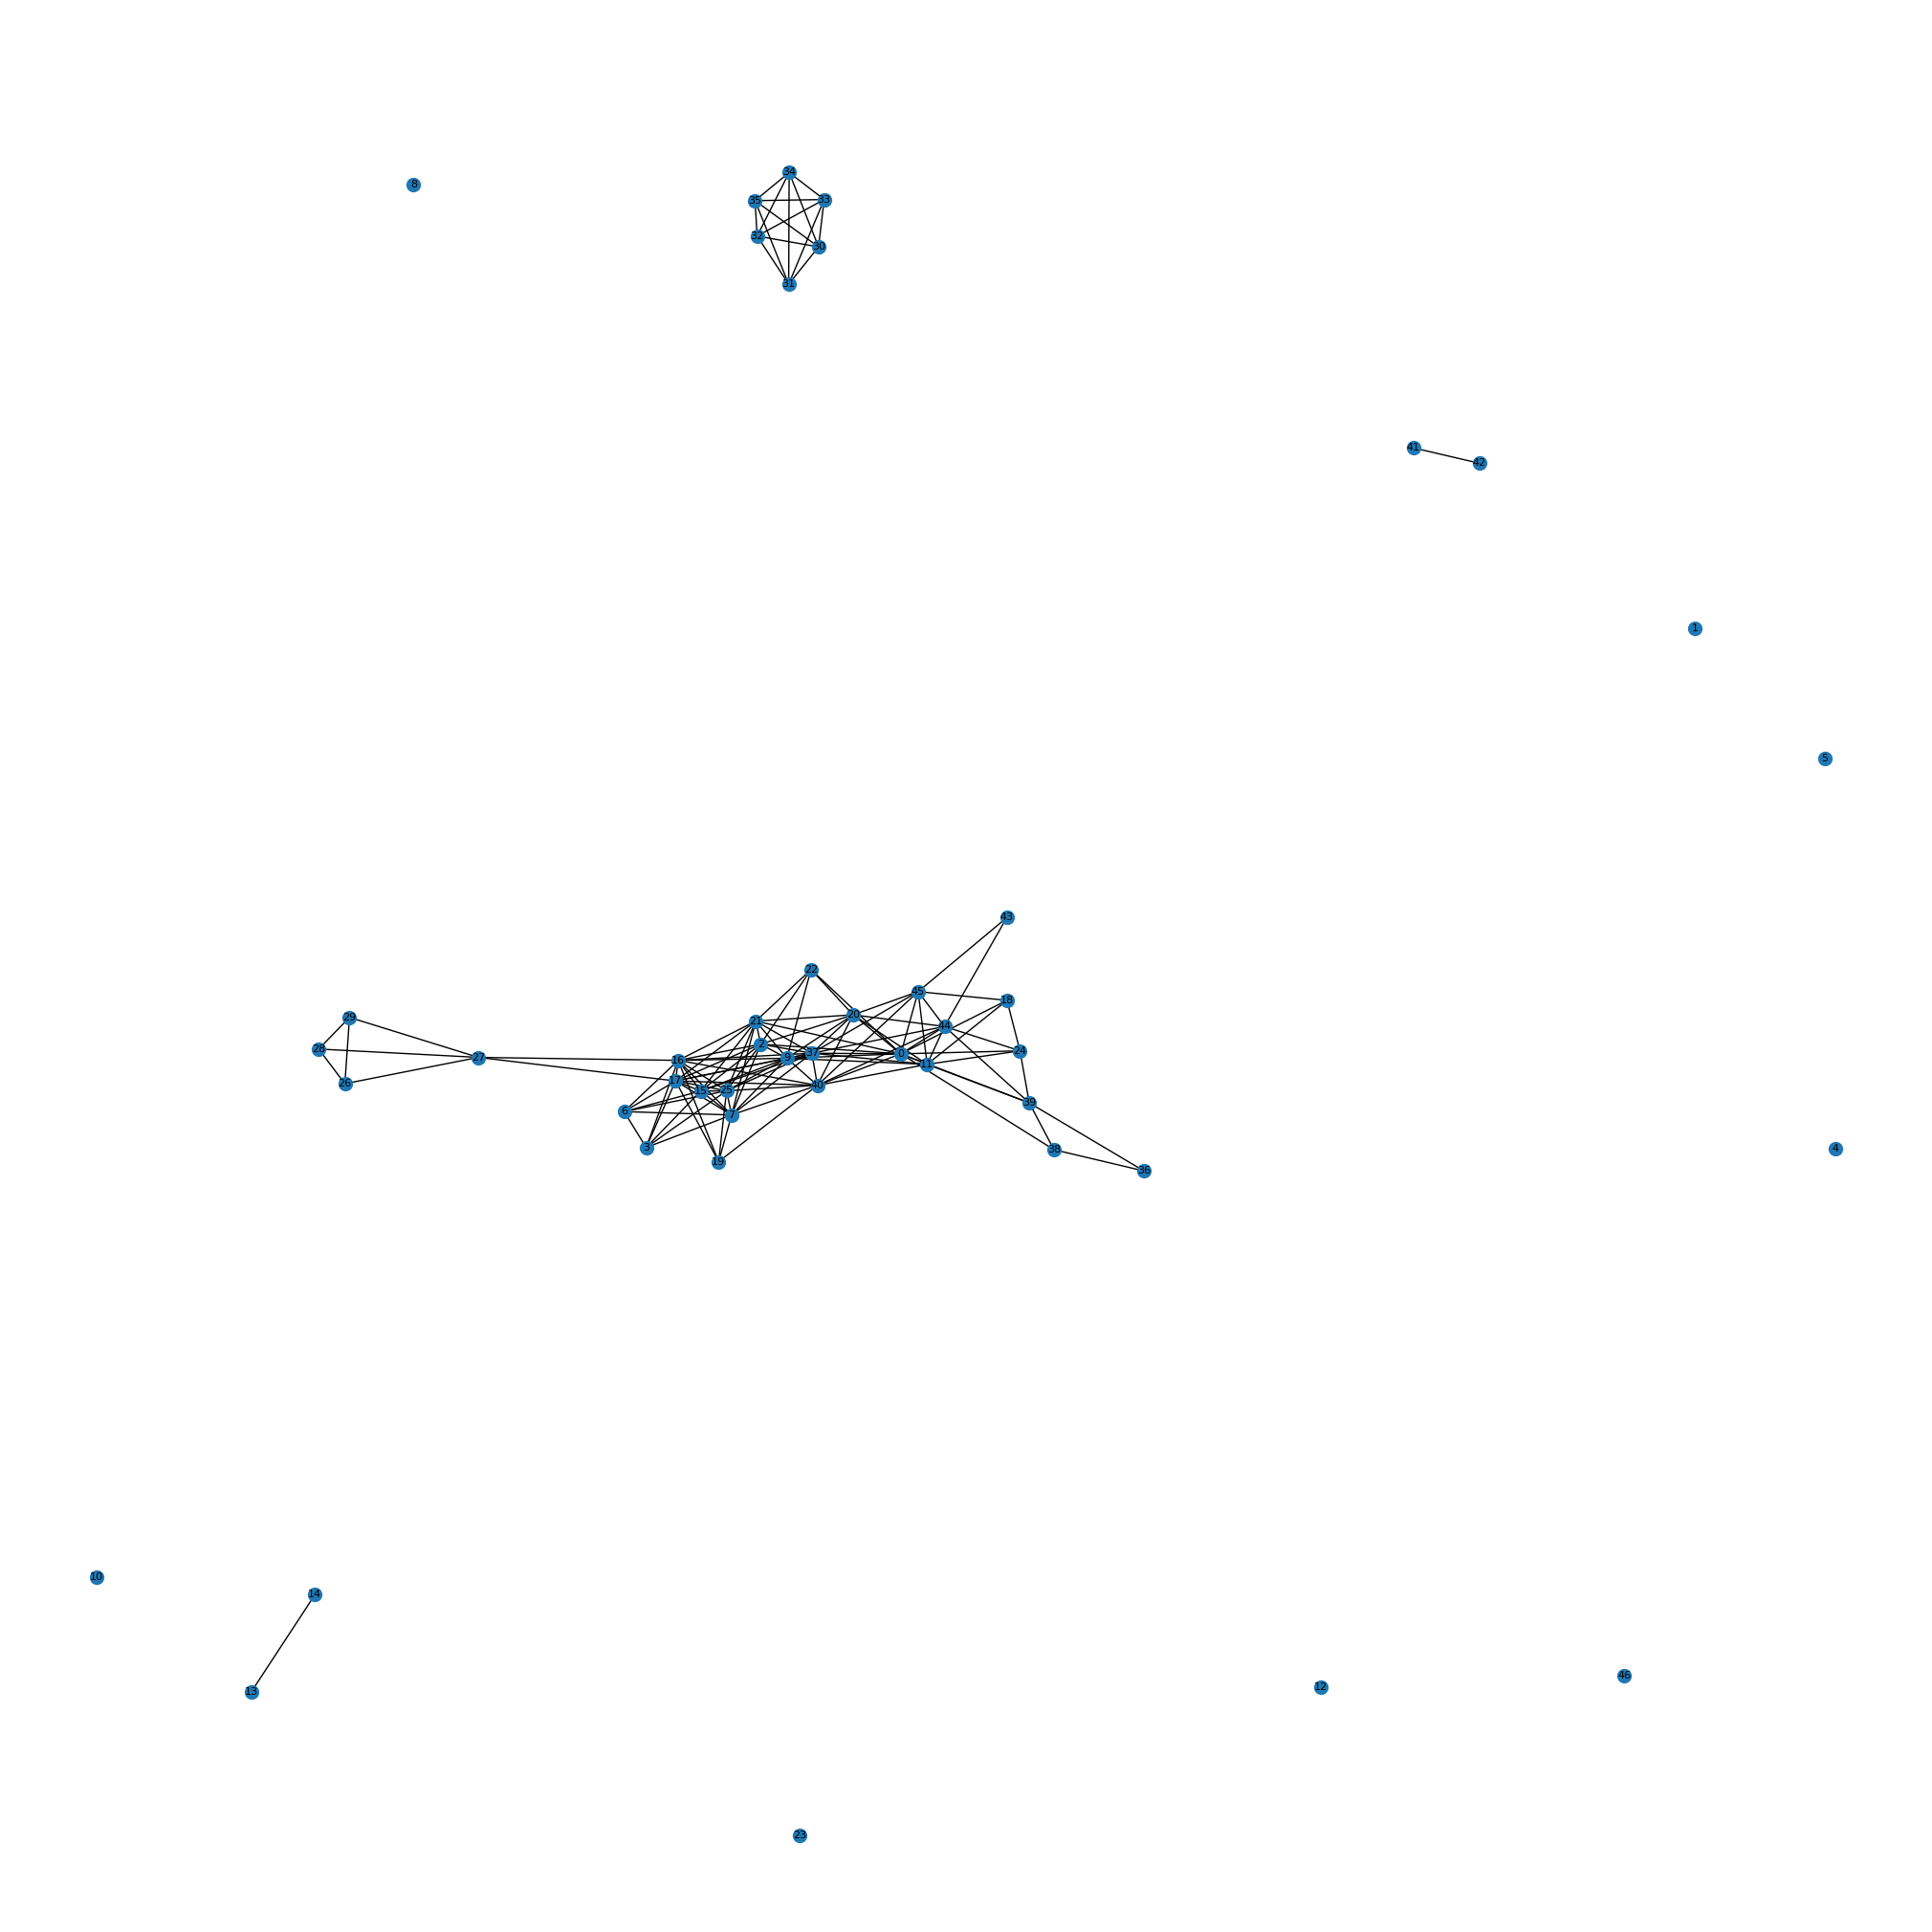

In [31]:
# Make a graph where nodes are views. Views are connected with edges if they share a column in their select clause.
G = nx.Graph()

# Add nodes
for index, row in df.iterrows():
    G.add_node(index, node_name=row['view_name']) #, node_cluster=row['cluster'])

# Add edges
for index, row in df.iterrows():
    for index2, row2 in df.iterrows():
        if index != index2:
            # check how many tables are shared between the two views
            columns1 = row['columns']
            columns2 = row2['columns']
            intersection = columns1.intersection(columns2)
            if intersection:
                G.add_edge(index, index2, edge_attr=intersection, edge_weight=len(intersection))

# Draw the graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.2, iterations=50)
nx.draw(G, pos, node_size=100, with_labels=True, font_size=8) #, node_color=[colormap(df.loc[node]['cluster']) for node in G.nodes()])
plt.show()

### Community detection 

In [32]:
communities = nx.algorithms.community.louvain_communities(G, weight='edge_weight', resolution=2)
print(communities)

for i, community in enumerate(communities):
    print(f'Community {i}:')
    for node in community:
        print(df.loc[node]['view_name'], '---', df.loc[node]['view_category'], '---', df.loc[node]['columns'])
    print('='*50)

[{1}, {4}, {5}, {8}, {10}, {12}, {13, 14}, {3, 6, 7, 15, 16, 17, 19, 25}, {18, 24, 43, 11, 44, 45}, {9, 2, 21, 22}, {23}, {26, 27, 28, 29}, {32, 33, 34, 35, 30, 31}, {36, 38, 39}, {40, 0, 20, 37}, {41, 42}, {46}]
Community 0:
sold_items --- entity --- {'__order_items_products.price_paid__', '__order_items_products.product_id__', '__order_items_products.category__', '__order_items_products.quantity__'}
Community 1:
customer_age_group_analysis --- relation --- {'__popular_products_by_age_group.product_name__', '__popular_products_by_age_group.total_orders__', '__age_groups.age_group__', '__age_groups.num_customers__', '__average_expenditure_per_age_group.average_order_cost__'}
Community 2:
top_5_months_by_orders --- entity --- {'__monthly_orders.order_year__', '__monthly_orders.order_count__', '__monthly_orders.order_month__'}
Community 3:
order_spending --- entity --- {'__orders_view.order_amount_spent__', '__orders_view.order_id__', '__orders_view.customer_id__'}
Community 4:
return_to